In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Input, Flatten, concatenate,LSTM,Dropout
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/sentiment_hotel_data_multi.csv')
data.head()

,Unnamed: 0,overall,cleanliness,location,rooms,service,value,title,text,username,num_cities,num_helpful_votes,num_reviews,num_type_reviews,id,date_stayed,offering_id,date,via_mobile,user_id
0,347763,5.0,5.0,5.0,5.0,5.0,5.0,“The place to be!”,While searching for a place to stay in San Ant...,billyburg_gal,6.0,0,6.0,NaN,133634921,June 2012,570285,"July 6, 2012",False,CB4EC484D7EF1C121CA07E4CEFE753F9
1,683165,5.0,4.0,4.0,4.0,5.0,5.0,“A lovely introduction to Memphis”,It is a bit out of the way but if you have car...,BethAilsa,4.0,0,9.0,5.0,130052739,May 2012,295791,"May 16, 2012",False,7484D9929DD349511DCA198F21CC7126
2,596197,2.0,1.0,3.0,2.0,5.0,3.0,“Not my favorite...”,The restaurant and bar staff were outstanding!...,Nailmark,24.0,0,40.0,8.0,123689053,January 2012,109138,"January 27, 2012",True,BB77722086A5C473515AA172FBDDD37C
3,164718,4.0,4.0,3.0,3.0,5.0,4.0,“Courteous and clean”,The hotel room was modern and the bed was comf...,LivingInParadise,4.0,2,6.0,NaN,119002043,September 2011,99354,"October 6, 2011",False,D46DD97DF2F410EFF7262D6F68CDE9F4
4,126383,4.0,5.0,5.0,4.0,5.0,4.0,“Great place to stay in the Big Apple!”,A friend and I travelling to NYC for my birthd...,Dentyne,4.0,5,18.0,5.0,130122332,April 2012,122005,"May 17, 2012",False,0483BA36417B757A2AED16EE41958A3B


In [ ]:
data = data[data.location.isin(['0.0','1.0','2.0','3.0','4.0','5.0'])]

In [ ]:
cls = ['cleanliness','location','rooms','service','value']
for cl in cls:
  data[cl] = np.asarray(data[cl]).astype(np.float64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
data = data[data['cleanliness']!=3]
data = data[data['location']!=3]
data = data[data['rooms']!=3]
data = data[data['service']!=3]
data = data[data['value']!=3]
data = data[data['overall']!=3]

In [ ]:
data.shape

(58359, 20)

In [ ]:

data['cleanliness_sent'] = data['cleanliness'].apply(lambda x : 1 if x> 3 else 0 )
data['location_sent'] = data['location'].apply(lambda x : 1 if x> 3 else 0 )
data['rooms_sent'] = data['rooms'].apply(lambda x : 1 if x> 3 else 0 )
data['service_sent'] = data['service'].apply(lambda x : 1 if x> 3 else 0 )
data['value_sent'] = data['value'].apply(lambda x : 1 if x> 3 else 0 )

data['Label'] = data['overall'].apply(lambda x : 1 if x> 3 else 0 )
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,Unnamed: 0,overall,cleanliness,location,rooms,service,value,title,text,username,...,offering_id,date,via_mobile,user_id,cleanliness_sent,location_sent,rooms_sent,service_sent,value_sent,Label
0,347763,5.0,5.0,5.0,5.0,5.0,5.0,“The place to be!”,While searching for a place to stay in San Ant...,billyburg_gal,...,570285,"July 6, 2012",False,CB4EC484D7EF1C121CA07E4CEFE753F9,1,1,1,1,1,1
1,683165,5.0,4.0,4.0,4.0,5.0,5.0,“A lovely introduction to Memphis”,It is a bit out of the way but if you have car...,BethAilsa,...,295791,"May 16, 2012",False,7484D9929DD349511DCA198F21CC7126,1,1,1,1,1,1
4,126383,4.0,5.0,5.0,4.0,5.0,4.0,“Great place to stay in the Big Apple!”,A friend and I travelling to NYC for my birthd...,Dentyne,...,122005,"May 17, 2012",False,0483BA36417B757A2AED16EE41958A3B,1,1,1,1,1,1
7,729781,1.0,1.0,5.0,1.0,1.0,1.0,“BED BUGS!”,Don't stay at this hotel. They have bedbugs. I...,almorris60745,...,84051,"July 2, 2012",False,C4BC9AF097113D5FBC61C163A626D68E,0,1,0,0,0,0
8,444718,5.0,5.0,5.0,5.0,5.0,5.0,“Spectacular Service!”,Wonderful and professional welcome from the st...,traveling_gal801,...,2015227,"March 15, 2012",False,1C780DE0AB3D20E1A22D3FDC854535B3,1,1,1,1,1,1


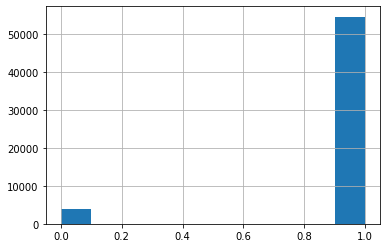

In [ ]:
data.Label.hist()

In [ ]:
pos_data = data[data['Label']==1].iloc[:3795]
neg_data = data[data['Label']==0].iloc[:3795]

In [ ]:
pos_data.shape , neg_data.shape

((3795, 26), (3795, 26))

In [ ]:
data = pd.concat([pos_data,neg_data])
data = data.sample(frac=1)
data.head()

,Unnamed: 0,overall,cleanliness,location,rooms,service,value,title,text,username,...,offering_id,date,via_mobile,user_id,cleanliness_sent,location_sent,rooms_sent,service_sent,value_sent,Label
57499,692416,2.0,1.0,2.0,2.0,2.0,2.0,“Dirty/smelly hotel”,As a Travel Agent i like to experience as many...,kglobal,...,125626,"December 12, 2007",False,FF4D56F15A274C83AF33D8E6A569382D,0,0,0,0,0,0
68,443347,5.0,5.0,5.0,5.0,5.0,4.0,“Visit to the Valley”,Picked this property out for an overnight visi...,Jill D,...,1200121,"December 6, 2012",False,69405DA4751D2AE12CBA55F5ADCADAFB,1,1,1,1,1,1
42272,360235,1.0,1.0,1.0,1.0,1.0,1.0,"“Dirty, Filthy, and Disgusting!”",Oh where to begin...okay how about the horribl...,socaltrav075,...,119746,"July 24, 2008",False,0A8D4B783458E1CB32FC9A657E2C6F4D,0,0,0,0,0,0
3200,500701,5.0,5.0,5.0,5.0,5.0,5.0,"“I love this hotel, especially for the...”","I love this hotel, especially for the price. C...",Cardesigner1,...,80823,"August 16, 2010",True,8AB3512EF907E582E26A162DB316791B,1,1,1,1,1,1
56600,272750,1.0,1.0,1.0,1.0,1.0,1.0,“Its awful”,Dont waste your money coming to this place. It...,rnikki,...,549441,"July 10, 2010",False,A022BE8A0CA3F0238832A58E192F977B,0,0,0,0,0,0


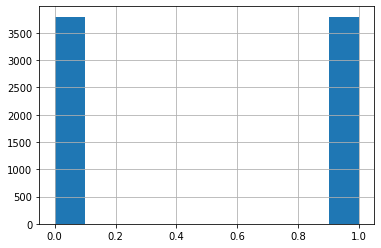

In [ ]:
data.Label.hist()

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import re
def remove_punc(line):
  line = re.sub('[0-9@]', '',line)
  line = re.sub('[#[]', '',line)
  line = re.sub(']', '',line)
  line = re.sub('[\'":,.?!&)(]', '',line)
  line = line.rstrip().lstrip()
  return line

data['text'] = data['text'].apply(lambda x : remove_punc(x))
data.text.values

array(['As a Travel Agent i like to experience as many places as possible\nMyself and a friend decided to go to Memphis and wanted the full experience of Elvis so decided to stay at the Heart Break hotel\nFirstly the hotel is only across the road from Gracelands so it is extremely easy to visit\nThis is the only good thing about this hotel\nLOCATION- Nearest to Gracelands but miles from aywhere else ie shops restuarnts bars etc a taxi to local mall is about  dollers round trip\nThere is a free shuttle which will take you to Beale Street but only runs evenings\nHOTEL- Looks nice as you walk in great for Elvis fans We were put in room  which was right by the public toilets so our room always smelt of poo and wee\nThe bed linen had blood and wee stains on it so we had to ask for it to be changed which was not much better\nTowels smelt musty and had old make up stains on them so again we asked for these to be changed which again was not much better\nAs a TRavel Agent i would recommend a ho

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
import nltk
from nltk.corpus import stopwords
stop_w = stopwords.words('english')

from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

data['text'] = data['text'].apply(lambda x : ' '.join([lemmatizer.lemmatize(w.lower()) for w in x.split(' ') if lemmatizer.lemmatize(w.lower()) not in stop_w ]))

data['text'] = data['text'].apply(lambda x : ' '.join([t for t in x.split(' ') if len(t)>0]))
    
data.text.values

array(['travel agent like experience many place possible\nmyself friend decided go memphis wanted full experience elvis decided stay heart break hotel\nfirstly hotel across road gracelands extremely easy visit\nthis good thing hotel\nlocation- nearest gracelands mile aywhere else ie shop restuarnts bar etc taxi local mall dollers round trip\nthere free shuttle take beale street run evenings\nhotel- look nice walk great elvis fan put room wa right public toilet room always smelt poo wee\nthe bed linen blood wee stain ask changed wa much better\ntowels smelt musty old make stain asked changed wa much better\nas travel agent would recommend hotel nearer beale street visit gracelands day\nwhoever said wa great must used type star holiday',
       'picked property overnight visit another area state wa convenient destination desk staff wa efficient friendly; common area inside spotless; room wa great - everything clean working order comfortable outstanding selection breakfast tended frequent

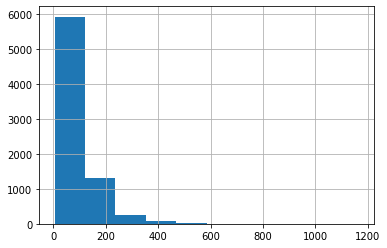

In [ ]:
data['length'] = data['text'].apply(lambda x : len(x.split(' ')))
data.length.hist()

In [ ]:
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 13.9 MB/s 
     |████████████████████████████████| 596 kB 61.9 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
     |████████████████████████████████| 6.6 MB 53.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, TFBertModel,pipeline
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
texts = []
labels = []
text = list(data.text.values)
label = list(data.Label.values)

for i in range(0,len(text),10):
  if (i % 1000) == 0:
    print(i)
  try:
    encoded_input = tokenizer(text[i:i+10], return_tensors='tf',max_length = 150,  # maximum length of a sentence  (TODO Figure the longest passage length)
      truncation = 'longest_first',padding='max_length'
    )
  
    output = model(encoded_input)
    for j in range(10):
      texts.append(np.copy(np.array(output['last_hidden_state'])[j]))
      labels.append(label[i+j])
  except:
    pass

0
1000
2000
3000
4000
5000
6000
7000


In [ ]:
import numpy as np

In [ ]:
texts = np.array(texts)

In [ ]:
labels = data[['cleanliness_sent','location_sent','rooms_sent','service_sent','value_sent']].values

In [ ]:
#texts[0].shape

In [ ]:
from sklearn.model_selection import train_test_split
text_train, text_test,label_train,label_test = train_test_split(texts,labels,test_size=0.2,random_state=24)

In [ ]:
texts = None

In [ ]:
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
def mod():
  sent_inp = Input(shape=(150, 768))
  X = Bidirectional(LSTM(512, return_sequences=True))(sent_inp)
  
  #X = Bidirectional(CuDNNLSTM(100,return_sequences=True))(X)
  #X = Dropout(0.4)(X)
  X = Bidirectional(LSTM(256,return_sequences=True))(X)
  X = Dropout(0.3)(X)
  X = Bidirectional(LSTM(128))(X)
  X = Dropout(0.2)(X)
  X = Dense(32,activation='relu')(X) 
  out = Dense(5,activation='sigmoid')(X)


  


  
  
  
  
  model = Model(inputs=sent_inp, 
                  outputs=out)
  
  return model


In [ ]:
model = mod()

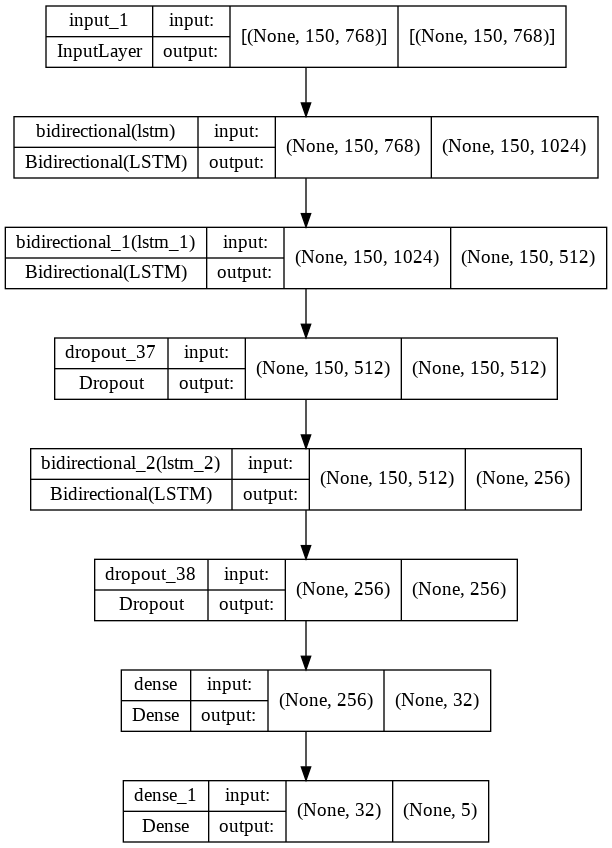

In [ ]:
tf.keras.utils.plot_model(model, to_file='img.png', show_shapes=True)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['binary_accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(text_train,label_train,validation_split=0.15,epochs=15,batch_size=64,callbacks=[callback])

Epoch 1/15
81/81 [==============================] - 33s 242ms/step - loss: 0.3799 - binary_accuracy: 0.8290 - val_loss: 0.2992 - val_binary_accuracy: 0.8685
Epoch 2/15
81/81 [==============================] - 17s 216ms/step - loss: 0.3001 - binary_accuracy: 0.8696 - val_loss: 0.2876 - val_binary_accuracy: 0.8768
Epoch 3/15
81/81 [==============================] - 18s 217ms/step - loss: 0.2713 - binary_accuracy: 0.8839 - val_loss: 0.2643 - val_binary_accuracy: 0.8933
Epoch 4/15
81/81 [==============================] - 17s 212ms/step - loss: 0.2618 - binary_accuracy: 0.8884 - val_loss: 0.2909 - val_binary_accuracy: 0.8768
Epoch 5/15
81/81 [==============================] - 17s 213ms/step - loss: 0.2425 - binary_accuracy: 0.8953 - val_loss: 0.2575 - val_binary_accuracy: 0.8894
Epoch 6/15
81/81 [==============================] - 17s 214ms/step - loss: 0.2362 - binary_accuracy: 0.8996 - val_loss: 0.2857 - val_binary_accuracy: 0.8744
Epoch 7/15
81/81 [==============================] - 17s 21

In [ ]:
pred = model.predict(text_test)

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(label_test, pred)
'accuracy on test data',m.result().numpy()

('accuracy on test data', 0.8905138)

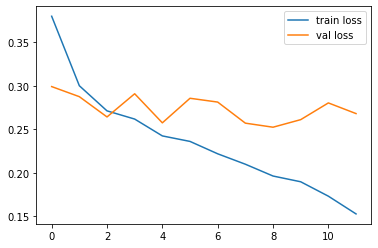

<Figure size 432x288 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('loss')

In [ ]:
model.save('/content/drive/MyDrive/model_multi_sentimentv2_withoutCuda.h5')